Import Libraries

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
from collections import Counter
import os


Download NLTK Resources

In [9]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/bshanmugam/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Load the Raw Dataset

In [ ]:

file_path = "Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv"
df = pd.read_csv(file_path)


print(f"Original shape: {df.shape}")
df = df[['reviews.text', 'reviews.rating']].dropna()
df = df[df['reviews.text'].str.strip() != '']
df.rename(columns={'reviews.text': 'text', 'reviews.rating': 'rating'}, inplace=True)
print(f"After removing missing: {df.shape}")
df.head(3)


Original shape: (5000, 24)
After removing missing: (5000, 2)


,text,rating
0,I thought it would be as big as small paper bu...,3
1,This kindle is light and easy to use especiall...,5
2,Didnt know how much i'd use a kindle so went f...,4


Visualize Ratings Distribution

/var/folders/7j/c3cwb7d17c1cfkhmkrqtw4q00000gn/T/ipykernel_5018/2570993220.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=df, palette='viridis')


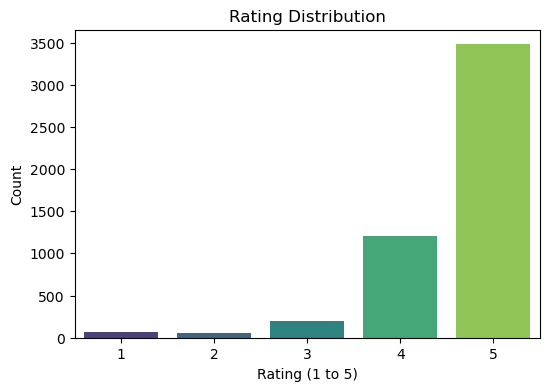

In [16]:
plt.figure(figsize=(6, 4))
sns.countplot(x='rating', data=df, palette='viridis')
plt.title("Rating Distribution")
plt.xlabel("Rating (1 to 5)")
plt.ylabel("Count")
plt.show()


Map Ratings to Sentiment Labels

/var/folders/7j/c3cwb7d17c1cfkhmkrqtw4q00000gn/T/ipykernel_5018/1546905546.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette='coolwarm')


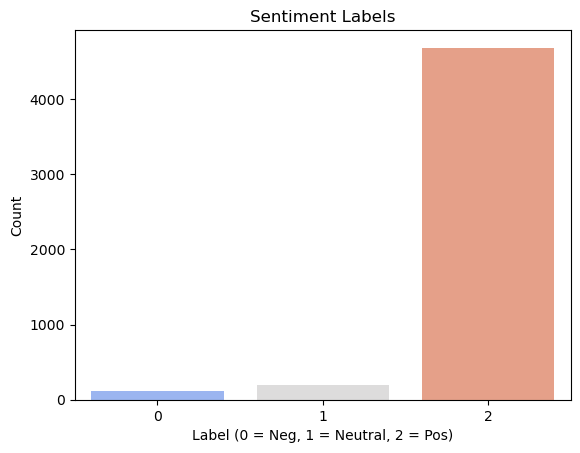

In [18]:
def rating_to_label(r):
    if r in [1, 2]:
        return 0 
    elif r == 3:
        return 1  
    else:
        return 2  

df['label'] = df['rating'].apply(rating_to_label)


sns.countplot(x='label', data=df, palette='coolwarm')
plt.title("Sentiment Labels")
plt.xlabel("Label (0 = Neg, 1 = Neutral, 2 = Pos)")
plt.ylabel("Count")
plt.show()


Clean Text (Simple + Stopwords + Stemming)

In [19]:
def simple_clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|@\w+|#\w+", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\d+", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    
    words = text.split()
    words = [stemmer.stem(word) for word in words if word not in stop_words]
    return " ".join(words)

df['clean_text'] = df['text'].apply(simple_clean_text)
df[['text', 'clean_text']].sample(3)


,text,clean_text
931,Love playing music and talking to Alexa and lo...,love play music talk alexa look camera three s...
3598,I bought two of these Fire Tablets for gifts f...,bought two fire tablet gift son thrill featur ...
3080,I bought this as a Christmas gift. I'm told th...,bought christma gift im told enjoy happi


Top Common Words per Sentiment Class

In [20]:
def get_top_n_words(texts, n=15):
    all_words = ' '.join(texts).split()
    return pd.DataFrame(Counter(all_words).most_common(n), columns=['word', 'count'])

for label, sentiment in zip([0, 1, 2], ['Negative', 'Neutral', 'Positive']):
    print(f"\n🔹 Top words for {sentiment} reviews:")
    top_words = get_top_n_words(df[df['label'] == label]['clean_text'])
    print(top_words)



🔹 Top words for Negative reviews:
      word  count
0      use     56
1   amazon     39
2     work     33
3   tablet     33
4   bought     30
5      app     30
6    kindl     28
7      buy     27
8      one     25
9    devic     24
10    year     23
11   would     22
12     get     22
13    last     21
14  return     20

🔹 Top words for Neutral reviews:
      word  count
0   tablet     82
1     good     53
2     work     47
3      use     44
4    great     37
5      app     35
6     time     32
7      kid     32
8     echo     29
9     read     28
10     one     28
11  amazon     28
12    like     27
13   price     27
14   would     25

🔹 Top words for Positive reviews:
       word  count
0      love   1688
1     great   1544
2       use   1488
3    tablet   1330
4      easi    805
5     kindl    768
6       one    735
7    bought    729
8      echo    685
9    amazon    653
10     read    605
11     good    602
12     like    591
13     work    572
14  purchas    529


Word Cloud per Sentiment Class

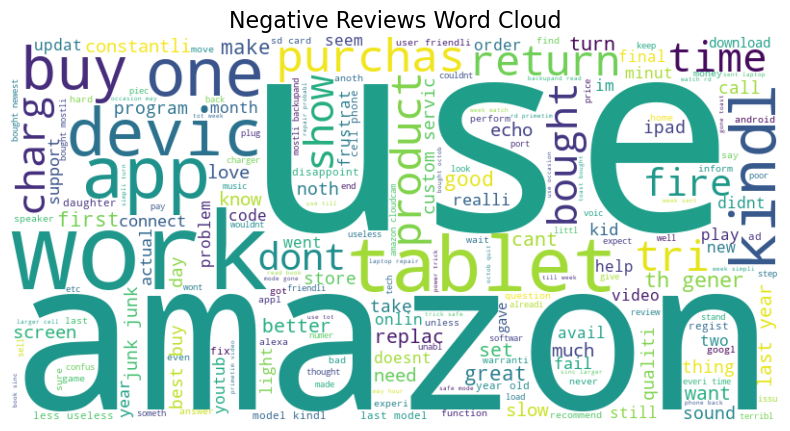

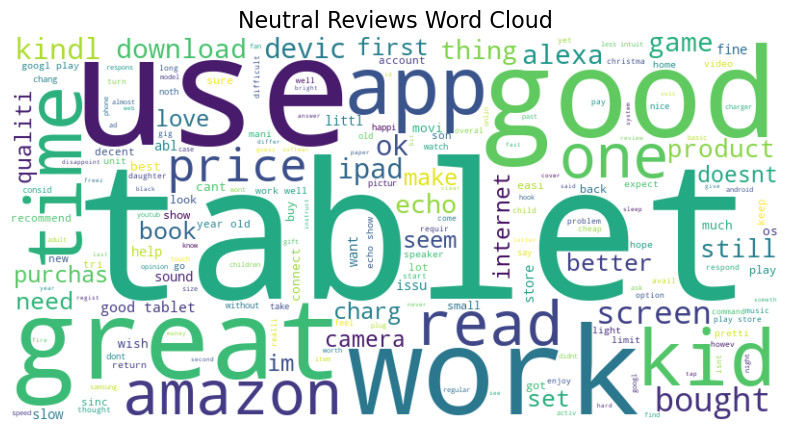

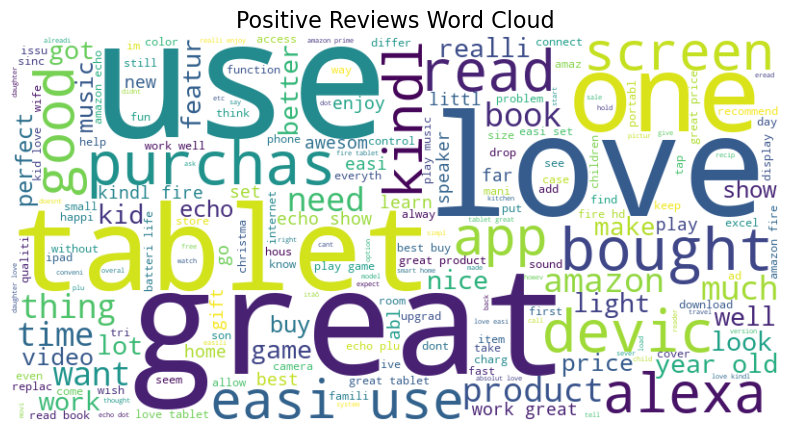

In [21]:
def plot_wordcloud(texts, title):
    text = ' '.join(texts)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=16)
    plt.show()

for label, sentiment in zip([0, 1, 2], ['Negative', 'Neutral', 'Positive']):
    plot_wordcloud(df[df['label'] == label]['clean_text'], f"{sentiment} Reviews Word Cloud")


Save the Final Cleaned Dataset

In [22]:
os.makedirs("data", exist_ok=True)
df[['clean_text', 'label']].to_csv("data/cleaned_amazon_reviews_final.csv", index=False)
print("✅ Saved: data/cleaned_amazon_reviews_final.csv")


✅ Saved: data/cleaned_amazon_reviews_final.csv
